# Evaluate State of Health Estimation 
Our data is generated from a model, so we know the what the state of health actually is.
Here, we evaluate how close the state estimation is to the known value

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm import ECMASOH, ECMTransientVector, ECMInput, ECMMeasurement
from moirae.simulator import Simulator
from batdata.data import BatteryDataset
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

Configuration

In [2]:
estimate_path = Path('../estimates/')  # Directory containing HDF files with the estimates
base_asoh = ECMASOH.model_validate_json(Path('../initial-asoh.json').read_text())

## Get a list of cells
Find all cells where we've finished running the state of health estimation

In [3]:
completed_cells = list(estimate_path.glob('*.hdf5'))
print(f'Found {len(completed_cells)} completed cells')

Found 39 completed cells


Load in a single cell as an example

In [4]:
example_cell = BatteryDataset.from_batdata_hdf(completed_cells[0])

## Compare Per-Cycle Estimates to True Value
We change the state of health parameter every cycle when generating the data, yet estimate it every timestep.
The following function compiles a per-cycle measurement for the estimated state-of-health

In [5]:
def get_asoh_comparison(cell: BatteryDataset) -> tuple[pd.DataFrame, list[str]]:
    """Extract only the per-cycle ASOH parameters, actual and estimated, from a cell dataset

    Args:
        cell: Cell to be evaluated
    Returns:
        - Dataframe containing the true and estimated ASOH parameters, and their difference
        - Names of the ASOH parameters being estimated
    """

    # Get the names of each type of column
    actual_asoh = [x for x in example_cell.cycle_stats.columns if x.startswith('actual_')]
    asoh_names = [x[7:] for x in actual_asoh]
    estimated_asoh = ['est_' + x for x in asoh_names]

    # Extract then compute the difference
    output = cell.cycle_stats[actual_asoh + estimated_asoh].copy()
    diff_asoh = ['diff_' + x for x in asoh_names]
    output[diff_asoh] = output[estimated_asoh].values - output[actual_asoh].values
    output['cycle_number'] = np.arange(len(output))
    return output, asoh_names

In [6]:
comparison, asoh_names = get_asoh_comparison(example_cell)

Show comparison for a single cell

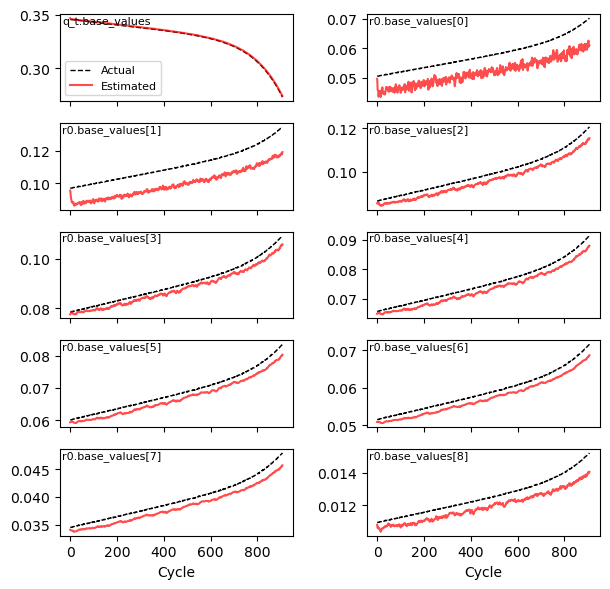

In [7]:
fig, axs = plt.subplots(len(asoh_names) // 2, 2, figsize=(6.2, 1.2 * len(asoh_names) // 2), sharex=True)

for name, ax in zip(asoh_names, axs.flatten()):
    ax.text(0.01, 0.99, name, fontsize=8, ha='left', va='top', transform=ax.transAxes)

    ax.plot(comparison.index, comparison[f'actual_{name}'], 'k--', label='Actual', lw=1)
    ax.plot(comparison.index, comparison[f'est_{name}'], 'r',  label='Estimated', alpha=0.7)

axs[0, 0].legend(fontsize=8)
for ax in axs[-1, :]:
    ax.set_xlabel('Cycle')

fig.tight_layout()
fig.savefig('figures/example-comparison.png', dpi=320)

Compute the mean absolute percentage error (MAPE) for each parameter for all cells a a function of cycle number

In [8]:
mape_summary = []
for i, cell_path in enumerate(tqdm(completed_cells)):
    my_cell = BatteryDataset.from_batdata_hdf(cell_path)
    my_comp, asoh_names = get_asoh_comparison(my_cell)

    # Get the per-cell MAPE
    mape_names = [f'mape_{n}' for n in asoh_names]
    my_comp[mape_names] = np.abs(my_comp[[f'diff_{n}' for n in asoh_names]].values / my_comp[[f'actual_{n}' for n in asoh_names]].values * 100)

    # Prepare to append to the output list
    my_comp['cell_id'] = i
    mape_summary.append(my_comp)
mape_summary = pd.concat(mape_summary, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [01:46<00:00,  2.73s/it]


Plot the range of MAPE parameters as a function of cycle

In [9]:
mape_stats = mape_summary.groupby('cycle_number')[mape_names].agg(['mean', 'std', 'count'])

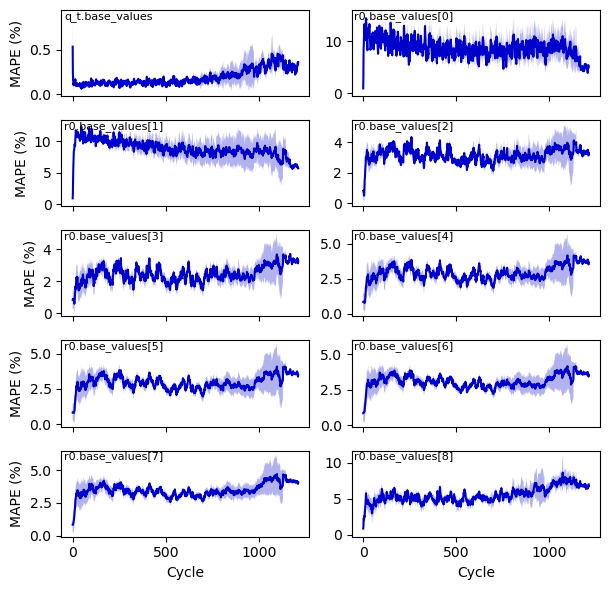

In [10]:
fig, axs = plt.subplots(len(asoh_names) // 2, 2, figsize=(6.2, 1.2 * len(asoh_names) // 2), sharex=True)

for name, ax in zip(asoh_names, axs.flatten()):
    ax.text(0.01, 0.99, name, fontsize=8, ha='left', va='top', transform=ax.transAxes)
    my_col = mape_stats[f'mape_{name}']
    
    ax.plot(my_col.index, my_col['mean'], color='mediumblue')
    ax.fill_between(my_col.index, my_col['mean'] + my_col['std'], my_col['mean'] - my_col['std'], color='mediumblue', alpha=0.3, edgecolor='none')

for ax in axs[-1, :]:
    ax.set_xlabel('Cycle')
for ax in axs[:, 0]:
    ax.set_ylabel('MAPE (%)')

fig.tight_layout()
fig.savefig('figures/mape-over-cycles.png', dpi=320)

## Evaluate Differences in Voltage Prediction
Instead of measuring the difference in parameter values, show their effect on the evaluated performance of the battery.

In [11]:
def reference_cycle_protocol(q_t: float):
    """
    Function to return list of ECMInputs corresponding to 1C discharge, 5 min rest, 1C charge

    Args: 
        q_t: Estimated charge capacity
    
    Yields:
        A progression of ECMInputs for the cycle
    """
    current_time = 0
    timestep_duration = 5   # units: s
    def update_timestamps_curr(current_time: float, duration: float, curr: float) -> None:
        """
        Helper to populate timestamps and currents.

        Args:
            duration: duration of segment in seconds
            curr: value of current to be used. 
        Yields: 
            A series of ECM inputs at gradually-increaseing times
        """
        steps = int(np.ceil(duration / timestep_duration))
        for time in np.linspace(current_time, current_time + duration, steps + 1)[:-1]:
            yield ECMInput(time=time, current=curr)

    # Discharge
    dischg_rate = 1.
    dischg_duration = 3600.0 / dischg_rate
    dischg_curr = -(q_t * dischg_rate)
    yield from update_timestamps_curr(current_time, duration=dischg_duration, curr=dischg_curr)
    current_time += dischg_duration

    # Rest 1
    rest1 = 5 * 60
    yield from update_timestamps_curr(current_time, duration=rest1, curr=0.0)
    current_time += rest1

    # Charge
    chg_rate = 1.
    ce = 1.0  # TODO (make adjustable)
    chg_duration = 3600.0 / chg_rate
    chg_curr = (q_t * chg_rate) / ce
    yield from update_timestamps_curr(current_time, duration=chg_duration, curr=chg_curr)
    current_time += chg_duration

In [12]:
def simulate_reference_cycle(asoh: ECM, q_t: float):
    """Run an ECM simulation for a single reference cycle

    Args:
        asoh: Cell health parameters
        q_t: estimated ASOH for the cell
    Returns:
        Simulator object ready with history already populated
    """

    state = ECMTransientVector(soc=1.)
    simulator = Simulator(
        model=ECM(),
        asoh=asoh,
        initial_input=ECMInput(),
        transient_state=state,
        keep_history=True
    )
    
    for inputs in reference_cycle_protocol(q_t):
        simulator.step(inputs)
    
    return simulator

In [13]:
simulator = simulate_reference_cycle(base_asoh, base_asoh.q_t.base_values)

Remove the index numbers from the ASOH names, so that we can use them to update an `HealthParameter` object

> TODO (wardlt): Make it so that the `update_parameters` function can handle updating a single value from a list. The code below is fragile because it asssumes that all variables from a particular list (e.g., `r_0[0]` and `r_0[1]`) are adjacent and in sorted order

In [14]:
hv_ready_names = [
    name[:-3] if name.endswith('[0]') else name
    for name in asoh_names
    if not (name.endswith(']') and not name.endswith('[0]'))
]
for h in hv_ready_names:
    base_asoh.mark_updatable(h)

In [15]:
perf_summary = []
for i, cell_path in enumerate(tqdm(completed_cells)):
    my_cell = BatteryDataset.from_batdata_hdf(cell_path)
    my_comp, asoh_names = get_asoh_comparison(my_cell)

    # Evaluate performance on some example cycles
    example_cycles = np.arange(0, 2000, 250)
    for cycle in example_cycles:
        if cycle >= len(my_comp):
            break
        my_cycle = my_comp.iloc[cycle]
        
        # Evaluate reference cycle using the estimated values
        est_values = my_cycle[[f'est_{n}' for n in asoh_names]].values
        est_asoh = base_asoh.model_copy(deep=True)
        est_asoh.update_parameters(est_values, names=hv_ready_names)
        est_simulator = simulate_reference_cycle(est_asoh, est_asoh.q_t.base_values)

        # Evaluate reference cycle using the actual values
        act_values = my_cycle[[f'actual_{n}' for n in asoh_names]].values
        act_asoh = base_asoh.model_copy(deep=True)
        act_asoh.update_parameters(act_values, names=hv_ready_names)
        act_simulator = simulate_reference_cycle(act_asoh, est_asoh.q_t.base_values)  # Use same q_t as est test
        
        # Store the estimated results
        sim_summary = pd.DataFrame({
            'time': [h.time.item() for h in est_simulator.input_history],
            'current': [h.current.item() for h in est_simulator.input_history],
            'est_voltage': [h.terminal_voltage.item() for h in est_simulator.measurement_history],
            'act_voltage': [h.terminal_voltage.item() for h in act_simulator.measurement_history],
        })
        sim_summary['cell'] = i
        sim_summary['cycle'] = cycle
        perf_summary.append(sim_summary)
perf_summary = pd.concat(perf_summary)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [06:04<00:00,  9.36s/it]


Plot the differences for a single cell

In [16]:
example_perf = perf_summary.query('cell == 0')

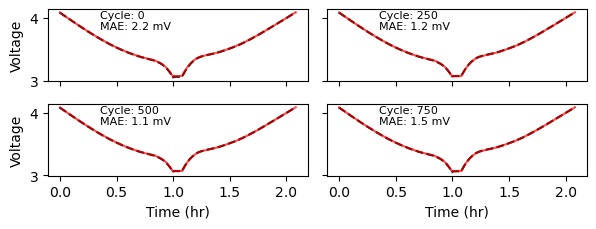

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(6.2, 1.2 * 2), sharex=True, sharey=True)

for (cycle_id, cycle_perf), ax in zip(example_perf.groupby('cycle'), axs.flatten()):
    my_col = mape_stats[f'mape_{name}']
    
    ax.plot(cycle_perf['time'] / 3600., cycle_perf['act_voltage'], 'k--', label='Actual')
    ax.plot(cycle_perf['time'] / 3600., cycle_perf['est_voltage'], 'r', label='Estimated', alpha=0.7)
    mae = (cycle_perf['est_voltage'] - cycle_perf['act_voltage']).abs().mean()
    ax.text(0.2, 0.99, f'Cycle: {cycle_id}\nMAE: {mae * 1000:.1f} mV', fontsize=8, ha='left', va='top', transform=ax.transAxes)
    

for ax in axs[-1, :]:
    ax.set_xlabel('Time (hr)')
for ax in axs[:, 0]:
    ax.set_ylabel('Voltage')

fig.tight_layout()
fig.savefig('figures/voltage-comparison-single-cell.png', dpi=320)

Summarize for all cells

In [18]:
perf_summary['error_abs'] = (perf_summary['act_voltage'] - perf_summary['est_voltage']).abs() * 1000

In [19]:
perf_by_cycle = perf_summary.groupby(['cycle', 'cell'])['error_abs'].mean().groupby('cycle').agg(['mean', 'std'])
perf_by_cycle

,mean,std
cycle,,
0,3.415726,2.364202
250,1.465844,0.304150
500,1.379629,0.337486
750,1.650215,0.448110
1000,2.463300,0.661094


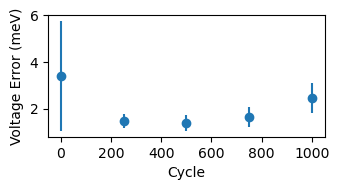

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.errorbar(perf_by_cycle.index, perf_by_cycle['mean'], yerr=perf_by_cycle['std'], fmt='o')

ax.set_xlabel('Cycle')
ax.set_ylabel('Voltage Error (meV)')

fig.tight_layout()